Volvemos a cargar datos del Drive y librerías

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import sys
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import PCA
from collections import defaultdict
import re
from time import time
import logging

In [4]:
WORKING_PATH = '/content'
%cd {WORKING_PATH}

/content


In [5]:
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.append(DRIVE_PATH)

In [6]:
!pwd

/content


In [7]:
!ls "{DRIVE_PATH}"

df_clean.csv  reviews_Clothing.json.gz


In [8]:
def parse(path):
  g = gzip.open(path, 'rb') # Abre el archivo gzip en modo binario de lectura
  for l in g:
    yield json.loads(l) # convierte la línea de JSON a un diccionario de Python

def getDF(path):
  i = 0
  df = {}
  for d in parse(path): # llamamos a la función parse() para obtener línea a línea
    df[i] = d # 'i' serán las claves del diccionario
    i += 1
  return pd.DataFrame.from_dict(df, orient='index') # convertie el diccionario a dataframe


In [9]:
df = getDF('/content/drive/MyDrive/Colab Notebooks/reviews_Clothing.json.gz')

In [10]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [11]:
df = df[['overall','reviewText']]
print(f'el shape del corpus es: {df.shape}')
print(f'\nvisualización 5 primeras instancias: \n{df.head()}')

el shape del corpus es: (278677, 2)

visualización 5 primeras instancias: 
   overall                                         reviewText
0      5.0  This is a great tutu and at a really great pri...
1      5.0  I bought this for my 4 yr old daughter for dan...
2      5.0  What can I say... my daughters have it in oran...
3      5.0  We bought several tutus at once, and they are ...
4      5.0  Thank you Halo Heaven great product for Little...


Me interesan solamente 2 columnas: "Overall" (valoraciones) y "reviewText" (opiniones)
Extraigo columnas:

In [12]:
df = df[['overall','reviewText']]
df.head()

,overall,reviewText
0,5.0,This is a great tutu and at a really great pri...
1,5.0,I bought this for my 4 yr old daughter for dan...
2,5.0,What can I say... my daughters have it in oran...
3,5.0,"We bought several tutus at once, and they are ..."
4,5.0,Thank you Halo Heaven great product for Little...


In [13]:
print(f'el nuevo shape del corpus es: {df.shape}')

el nuevo shape del corpus es: (278677, 2)


Añadimos la columna Sentimet.

Para valores de opiniones =>4, damos valor de 1.
Para valores  inferiores a 4, damos valor de 0.

In [14]:
df['sentiment'] = df['overall'].apply(lambda x: 1 if x >= 4 else 0)
df.head()

,overall,reviewText,sentiment
0,5.0,This is a great tutu and at a really great pri...,1
1,5.0,I bought this for my 4 yr old daughter for dan...,1
2,5.0,What can I say... my daughters have it in oran...,1
3,5.0,"We bought several tutus at once, and they are ...",1
4,5.0,Thank you Halo Heaven great product for Little...,1


In [15]:
print(f'el nuevo shape del corpus es: {df.shape}')

el nuevo shape del corpus es: (278677, 3)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     278677 non-null  float64
 1   reviewText  278677 non-null  object 
 2   sentiment   278677 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.5+ MB


Visualizamos si hay valores con NaN, por si tenemos que eliminarlos:

In [17]:
df.isnull().sum()

,0
overall,0
reviewText,0
sentiment,0


In [18]:
df = df.dropna().drop_duplicates()
df.dropna(inplace=True)
df.isnull().sum()

,0
overall,0
reviewText,0
sentiment,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278569 entries, 0 to 278676
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     278569 non-null  float64
 1   reviewText  278569 non-null  object 
 2   sentiment   278569 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.5+ MB


Vamos a ver cuántas palabras tiene el corpus:

In [20]:
corpus = df['reviewText'].str.cat(sep=' ')
print(f'el corpus tiene {len(corpus)} caracteres')
print('----------------------------------------------------------------------------------------')
print(f'Ejemplo de las 100 primeros caracteres:')
print()
print(corpus[:99])

el corpus tiene 88127104 caracteres
----------------------------------------------------------------------------------------
Ejemplo de las 100 primeros caracteres:

This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looke


De estas palabras,vamos a ver el número de las palabras más repetidas, ya que consideraremos que son "stopwords",y las quitaremos:

In [21]:
from collections import Counter

def most_common(review, number):
  words_nltk = review.split()
  wf = Counter(words_nltk)
  return wf.most_common(number), words_nltk

In [22]:
most_common_words, words_nltk = most_common(corpus, 10)

In [23]:
most_common_words

[('the', 625745),
 ('I', 615568),
 ('and', 522159),
 ('a', 457806),
 ('to', 344122),
 ('is', 270044),
 ('it', 235243),
 ('for', 225220),
 ('of', 204872),
 ('in', 184496)]

In [24]:
# Función para eliminar stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and word not in ['one']]
    return " ".join(filtered_words)

corpus_without_stopwords = remove_stopwords(corpus)

print(f'el corpus sin stopwords: {len(corpus_without_stopwords)} caracteres')
print('----------------------------------------------------------------------------------------')
print(f'Ejemplo de las 100 primeros caracteres:')
print()
print(corpus_without_stopwords[:99])

# Recálculo de las palabras más usadas tras suprimir stopwords:
most_common_words_no_stopwords, words_nltk_no_stopwords = most_common(corpus_without_stopwords, 10)
most_common_words_no_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


el corpus sin stopwords: 60265097 caracteres
----------------------------------------------------------------------------------------
Ejemplo de las 100 primeros caracteres:

This great tutu really great price. It look cheap all. I'm glad I looked Amazon found affordable tu


[('I', 615568),
 ('The', 103063),
 ('like', 84831),
 ('wear', 70770),
 ('size', 64482),
 ('fit', 64366),
 ('They', 58388),
 ('would', 57785),
 ('It', 55661),
 ('This', 49323)]

# DIVISIÓN PARA TRAIN Y TEST

In [25]:
from sklearn.model_selection import train_test_split

#Estratificamos por la variable objetivo a 80-20:
train, test = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)

In [26]:
print(f'DATOS PARA TRAIN: {train.shape}')
print(f'DATOS PARA TEST: {test.shape}')

DATOS PARA TRAIN: (222855, 3)
DATOS PARA TEST: (55714, 3)


Una vez obtenido la separación, guardamos para obtener los csv, que luego utilizaremos:

In [27]:
train.to_csv('/content/drive/MyDrive/NLP_KeepCoding/Project/train.csv', index=False)
test.to_csv('/content/drive/MyDrive/NLP_KeepCoding/Project/test.csv', index=False)

Volviendo a lo que nos pide la práctica, recapitulamos:

* Cardinalidad del vocabulario
* Distribución de reviews por número de estrellas
* Nº de reviews positivas y negativas
* N-grams más frecuentes
* Nubes de palabras
* Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)
* Conclusiones de la exploración
* Cualquier otra métrica / exploración / cálculo que el alumno considere

# Cardinalidad

In [28]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["reviewText"])
vocabulary = vectorizer.vocabulary_
cardinality = len(vocabulary)
print(f"Cardinalidad del vocabulario: {cardinality}")

Cardinalidad del vocabulario: 78587


Relacionamos número total de palabras con palabras únicas:

In [29]:
total_words = df["reviewText"].dropna().apply(lambda x: len(x.split())).sum()
riqueza=cardinality/total_words
print(f"La riqueza léxica del texto es: {riqueza}")

La riqueza léxica del texto es: 0.004703827987151039


La relación del número total de palabras con el número de palabras única es del 0.47%. De esto podemos apreciar que los textos son diversos, ofreciendo un amplio vocabulario en las opiniones de los clientes.

# DISTRIBUCIÓN
Vamos a hacer una pequeña gráfica, para saber la distribución de estrellas del dataset.

<ipython-input-30-f956ac0399dc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["overall"].value_counts().sort_index().index,


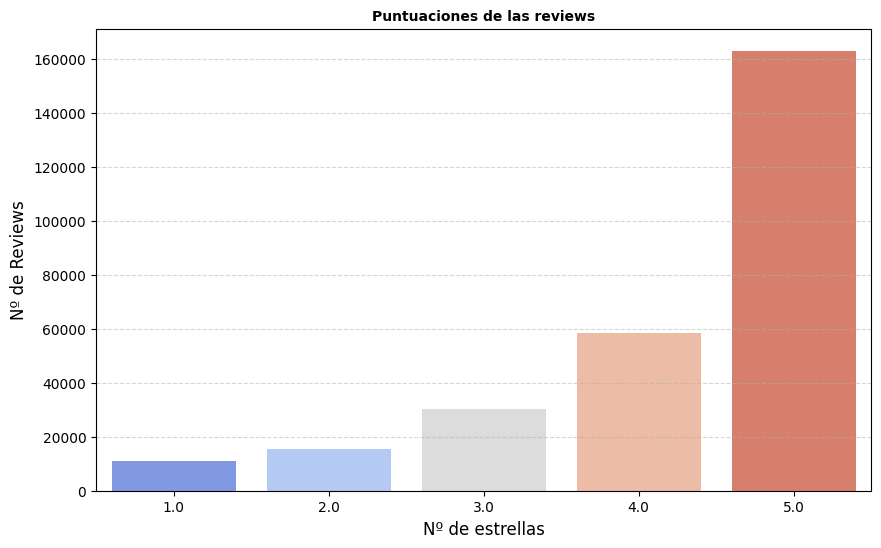

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["overall"].value_counts().sort_index().index,
            y=df["overall"].value_counts().sort_index().values,
            palette="coolwarm")

# Personalización del gráfico
plt.title("Puntuaciones de las reviews", fontsize=10, fontweight="bold")
plt.xlabel("Nº de estrellas", fontsize=12)
plt.ylabel("Nº de Reviews", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Mostrar gráfico mejorado
plt.show()

# Nº de reviews positivas y negativas

Para poner en contexto, vamos a realizar un pequeño histograma, donde separaremos reviews positivas y negativas.
Según hemos establecido, opiniones por encima de 4, serán positivas, mientras que el resto, serán negativas.
Previamente, haremos unas adiciones en el dataset:

<ipython-input-31-aff4aa5b1f46>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=assessment_counts.index, y=assessment_counts.values, palette="coolwarm")


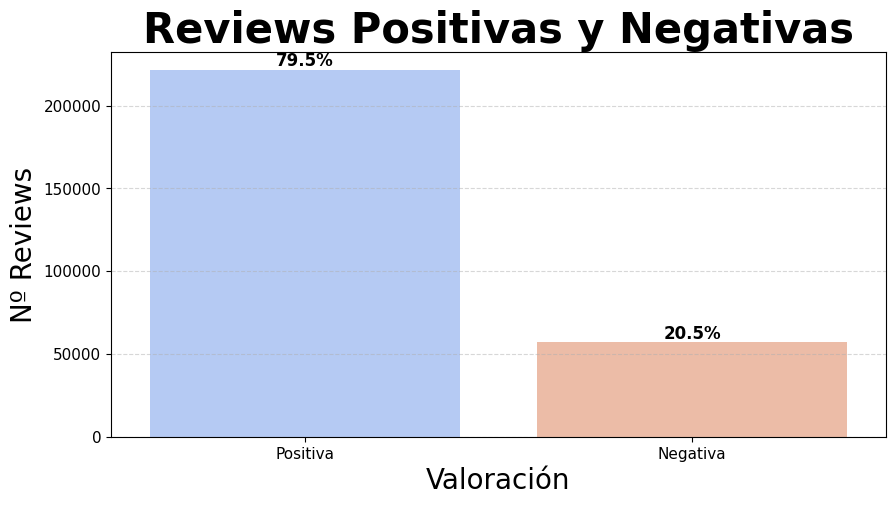

In [31]:
# 1. Creación de nueva columna para clasificar las reviews en positivas y negativas
df["assessment"] = df["overall"].apply(lambda x: "Positiva" if x >= 4 else "Negativa")

# 2. Conteo el número de reviews positivas y negativas
assessment_counts = df["assessment"].value_counts()

# 3. Calcular los porcentajes
total_reviews = assessment_counts.sum()
percentage_labels = [(count / total_reviews) * 100 for count in assessment_counts]


# Con esto, ya podemos crear nuestro histograma:

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=assessment_counts.index, y=assessment_counts.values, palette="coolwarm")

# Añadir etiquetas con los porcentajes
for i, p in enumerate(ax.patches):
    ax.annotate(f"{percentage_labels[i]:.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=12, fontweight="bold")

# Personalización del gráfico
plt.title("Reviews Positivas y Negativas", fontsize=30, fontweight="bold")
plt.xlabel("Valoración", fontsize=20)
plt.ylabel("Nº Reviews", fontsize=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


Por los porcentajes, podemos apreciar que las opiiniones son positivas prevalecen sobre las negativas.

# N_GRAMS MÁS FRECUENTES
Para el análisis de los N-grams, por simplificar, nos centramos en los bigramas y trigramas:

In [32]:
!pip install -U nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [33]:
bigrams_ = list(ngrams(most_common_words_no_stopwords, 2))
trigrams_ = list(ngrams(most_common_words_no_stopwords, 3))

In [34]:
bigrams_[:10]

[(('I', 615568), ('The', 103063)),
 (('The', 103063), ('like', 84831)),
 (('like', 84831), ('wear', 70770)),
 (('wear', 70770), ('size', 64482)),
 (('size', 64482), ('fit', 64366)),
 (('fit', 64366), ('They', 58388)),
 (('They', 58388), ('would', 57785)),
 (('would', 57785), ('It', 55661)),
 (('It', 55661), ('This', 49323))]

In [35]:
trigrams_[:10]

[(('I', 615568), ('The', 103063), ('like', 84831)),
 (('The', 103063), ('like', 84831), ('wear', 70770)),
 (('like', 84831), ('wear', 70770), ('size', 64482)),
 (('wear', 70770), ('size', 64482), ('fit', 64366)),
 (('size', 64482), ('fit', 64366), ('They', 58388)),
 (('fit', 64366), ('They', 58388), ('would', 57785)),
 (('They', 58388), ('would', 57785), ('It', 55661)),
 (('would', 57785), ('It', 55661), ('This', 49323))]

# NUBE DE PALABRAS

In [36]:
!pip install wordcloud

In [37]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="white").generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

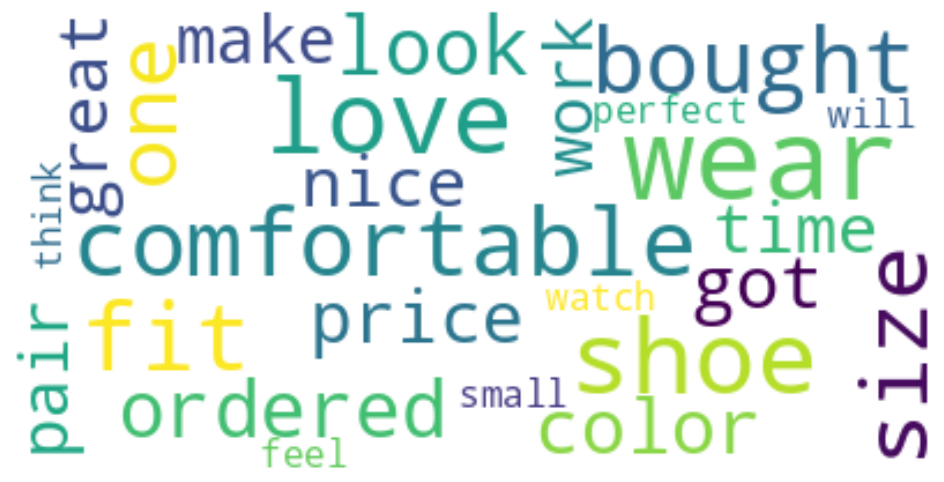

In [38]:
text=" ".join(df["reviewText"].dropna())
words_list = text.lower().strip().split()
plot_word_cloud(text.lower())

# VISUALIZACIÓN WORD EMBEDDINGS CON WORD2VEC

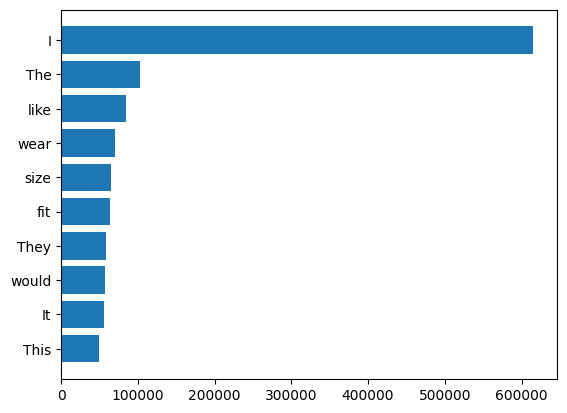

In [39]:
words = [w[0] for w in most_common_words_no_stopwords]
freqs = [w[1] for w in most_common_words_no_stopwords]

freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

Tras ver un diagráma con las repeticiones de las 10 palabras más utilizadas, realizamos un modelo Word2Vec.

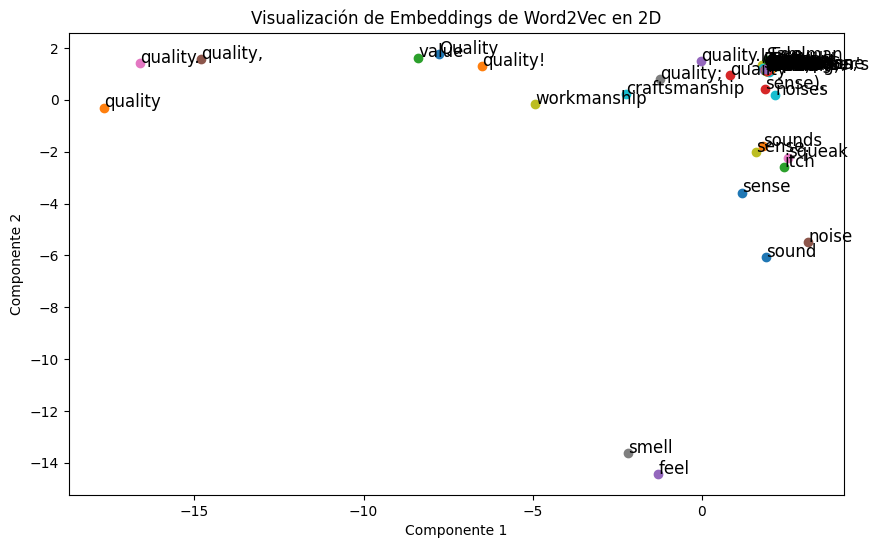

In [41]:
# Tokenizar las reviews preprocesadas
df["tokenized_review"] = df["reviewText"].dropna().apply(lambda x: x.split())

# Entrenar el modelo Word2Vec
word2vec_model = Word2Vec(sentences=df["tokenized_review"], vector_size=100, window=5, min_count=5, workers=4)

# Elegir algunas palabras clave para analizar similitudes
words_to_visualize = ["sound", "quality", "guitar", "bass", "microphone"]

# Obtener las palabras más similares a cada una
similar_words = {}
for word in words_to_visualize:
    if word in word2vec_model.wv:
        similar_words[word] = [w[0] for w in word2vec_model.wv.most_similar(word, topn=10)]

# Extraer los embeddings de las palabras seleccionadas
all_words = words_to_visualize + [w for words in similar_words.values() for w in words]
word_vectors = np.array([word2vec_model.wv[w] for w in all_words if w in word2vec_model.wv])

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# Crear el gráfico de embeddings en 2D
plt.figure(figsize=(10, 6))
for i, word in enumerate(all_words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.text(reduced_vectors[i, 0] + 0.01, reduced_vectors[i, 1] + 0.01, word, fontsize=12)

plt.title("Visualización de Embeddings de Word2Vec en 2D")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

# CONCLUSIONES DEL ANÁLISIS

Tras el análisis inicial,podemos comprobar que al ser un dataset con 500k reviews, podemos considerar que dispone un corpus amplio y con muchos caracteres únicos, y que la limpieza que hemos realizado, ha reducido poco el tamaño de dicho corpus.

Del análisis también podemos sacar la conclusión que las valoraciones positivas (>4)de los clientes roza el 80%

Antes de finalizar esta parte de la práctica, guardamos el corpus para la siguiente parte:

In [42]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/df_clean.csv')